##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image Segmenter

## Imports and Setup
Let's start with the base imports for running this MediaPipe sample.

In [1]:
!pip install -q mediapipe

## Download the image segmenter model

The next thing you will need to do is download the image segmentation model that will be used for this demo. In this case you will use the DeepLab v3 model.

In [1]:
import requests

# URL untuk model dan gambar uji
model_url = "https://storage.googleapis.com/mediapipe-models/image_segmenter/deeplab_v3/float32/1/deeplab_v3.tflite"

# Fungsi untuk mendownload file dari URL
def download_file(url, filename):
    response = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(response.content)

# Download model deeplabv3.tflite
download_file(model_url, "deeplabv3.tflite")

print("Download completed!")


Download completed!


## Download a test image

After downloading the model, it's time to grab an image that you can use for testing! It's worth noting that while this is working with a single image, you can download a collection of images to store in the `IMAGE_FILENAMES` array.

In [2]:
import urllib

IMAGE_FILENAMES = ['segmentation_input_rotation0.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-assets/{name}'
  urllib.request.urlretrieve(url, name)

## Preview the downloaded image

With the test image downloaded, go ahead and display it.

In [5]:
import cv2
import math

# Height and width that will be used by the model
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

# Performs resizing and showing the image
def resize_and_show(image):
    h, w = image.shape[:2]
    if h < w:
        img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h / (w / DESIRED_WIDTH))))
    else:
        img = cv2.resize(image, (math.floor(w / (h / DESIRED_HEIGHT)), DESIRED_HEIGHT))
    cv2.imshow('Resized Image', img)
    cv2.waitKey(0)  # Wait until a key is pressed to close the window
    cv2.destroyAllWindows()  # Close the image window

# List of image filenames (ensure IMAGE_FILENAMES is defined with the filenames)
IMAGE_FILENAMES = ['image1.jpg']  # Example filenames

# Preview the image(s)
images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
    print(name)
    resize_and_show(image)


image1.jpg


## Running inference and visualizing the results
To run inference using the image segmentation MediaPipe Task, you will need to initialize the `ImageSegmenter` using the model. This example will separate the background and foreground of the image and apply separate colors for them to highlight where each distinctive area exists. Image segmentation here will use a category mask, which applies a category to each found item based on confidence.

In [4]:
import numpy as np
import mediapipe as mp

from mediapipe.tasks import python
from mediapipe.tasks.python import vision


BG_COLOR = (192, 192, 192) # gray
MASK_COLOR = (255, 255, 255) # white


# Create the options that will be used for ImageSegmenter
base_options = python.BaseOptions(model_asset_path='deeplabv3.tflite')
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_category_mask=True)

# Create the image segmenter
with vision.ImageSegmenter.create_from_options(options) as segmenter:

  # Loop through demo image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe image file that will be segmented
    image = mp.Image.create_from_file(image_file_name)

    # Retrieve the masks for the segmented image
    segmentation_result = segmenter.segment(image)
    category_mask = segmentation_result.category_mask

    # Generate solid color images for showing the output segmentation mask.
    image_data = image.numpy_view()
    fg_image = np.zeros(image_data.shape, dtype=np.uint8)
    fg_image[:] = MASK_COLOR
    bg_image = np.zeros(image_data.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR

    condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.2
    output_image = np.where(condition, fg_image, bg_image)

    print(f'Segmentation mask of {name}:')
    resize_and_show(output_image)

Segmentation mask of image1.jpg:


Now that you know how to separate the foreground and background of an image, let's take it a step further and blur the background for an effect similar to what is provided by Google Hangouts.

In [6]:
# Blur the image background based on the segmentation mask.

# Create the segmenter
with python.vision.ImageSegmenter.create_from_options(options) as segmenter:

  # Loop through available image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe Image
    image = mp.Image.create_from_file(image_file_name)

    # Retrieve the category masks for the image
    segmentation_result = segmenter.segment(image)
    category_mask = segmentation_result.category_mask

    # Convert the BGR image to RGB
    image_data = cv2.cvtColor(image.numpy_view(), cv2.COLOR_BGR2RGB)

    # Apply effects
    blurred_image = cv2.GaussianBlur(image_data, (55,55), 0)
    condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.1
    output_image = np.where(condition, image_data, blurred_image)

    print(f'Blurred background of {image_file_name}:')
    resize_and_show(output_image)

Blurred background of image1.jpg:


In [7]:
# Create the segmenter
with python.vision.ImageSegmenter.create_from_options(options) as segmenter:

    # Loop through available image(s)
    for image_file_name in IMAGE_FILENAMES:

        # Create the MediaPipe Image
        image = mp.Image.create_from_file(image_file_name)

        # Retrieve the category masks for the image
        segmentation_result = segmenter.segment(image)
        category_mask = segmentation_result.category_mask

        # Convert the BGR image to RGB
        image_data = cv2.cvtColor(image.numpy_view(), cv2.COLOR_BGR2RGB)

        # Create a blue background
        blue_background = np.zeros_like(image_data)
        blue_background[:, :] = [0, 0, 255]  # RGB color for blue

        # Create a condition mask from the category mask
        condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.1

        # Apply the blue background to non-segmented areas
        output_image = np.where(condition, image_data, blue_background)

        print(f'Applied blue background to {image_file_name}:')
        resize_and_show(output_image)


Applied blue background to image1.jpg:


In [8]:
#blurring

import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Define constants for desired height and width
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

BG_COLOR = (192, 192, 192)  # gray

# Create the options for ImageSegmenter
base_options = python.BaseOptions(model_asset_path='deeplabv3.tflite')
options = vision.ImageSegmenterOptions(base_options=base_options, output_category_mask=True)

# Create the image segmenter
with vision.ImageSegmenter.create_from_options(options) as segmenter:

    # Capture video from webcam
    vid = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    
    if not vid.isOpened():
        print("Error opening the video file")
        exit()

    while vid.isOpened():
        ret, frame = vid.read()
        if not ret:
            break

        # Convert the frame to RGB as required by MediaPipe
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Create MediaPipe image from frame
        image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
        
        # Perform segmentation
        segmentation_result = segmenter.segment(image)
        category_mask = segmentation_result.category_mask

        # Convert back to BGR for OpenCV processing
        frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)

        # Apply Gaussian blur to the background
        blurred_image = cv2.GaussianBlur(frame_bgr, (55, 55), 0)
        
        # Create a condition for where the foreground is
        condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.1
        
        # Create the output image by blending the original frame and the blurred image
        output_image = np.where(condition, frame_bgr, blurred_image)

        # Display the resulting frame
        cv2.imshow('Segmented Video', output_image)

        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture object and close display window
    vid.release()
    cv2.destroyAllWindows()


In [9]:
#warna merah

import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Define constants for desired height and width
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

BG_COLOR = (0, 0, 255)  # blue

# Create the options for ImageSegmenter
base_options = python.BaseOptions(model_asset_path='deeplabv3.tflite')
options = vision.ImageSegmenterOptions(base_options=base_options, output_category_mask=True)

# Create the image segmenter
with vision.ImageSegmenter.create_from_options(options) as segmenter:

    # Capture video from webcam
    vid = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    
    if not vid.isOpened():
        print("Error opening the video file")
        exit()

    while vid.isOpened():
        ret, frame = vid.read()
        if not ret:
            break

        # Convert the frame to RGB as required by MediaPipe
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Create MediaPipe image from frame
        image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
        
        # Perform segmentation
        segmentation_result = segmenter.segment(image)
        category_mask = segmentation_result.category_mask

        # Convert back to BGR for OpenCV processing
        frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)

        # Create a blue background
        blue_background = np.zeros_like(frame_bgr)
        blue_background[:] = BG_COLOR

        # Create a condition for where the foreground is
        condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.1
        
        # Create the output image by applying the blue background to non-segmented areas
        output_image = np.where(condition, frame_bgr, blue_background)

        # Display the resulting frame
        cv2.imshow('Segmented Video', output_image)

        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture object and close display window
    vid.release()
    cv2.destroyAllWindows()


C:\Users\mohsu\AppData\Local\Temp\ipykernel_3400\2492564920.py:34: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(title, font=font)
C:\Users\mohsu\AppData\Local\Temp\ipykernel_3400\2492564920.py:34: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(title, font=font)
C:\Users\mohsu\AppData\Local\Temp\ipykernel_3400\2492564920.py:34: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(title, font=font)


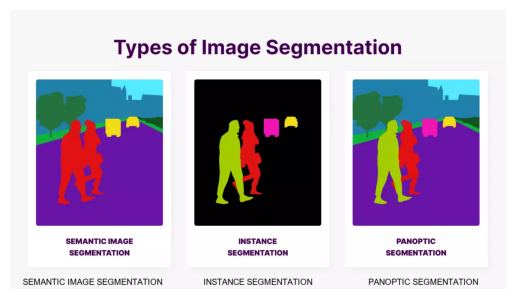

In [2]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Load the provided image
image_path = "types-of-image-segmentation-1.webp"
original_image = Image.open(image_path)

# Create the titles
titles = ["SEMANTIC IMAGE SEGMENTATION", "INSTANCE SEGMENTATION", "PANOPTIC SEGMENTATION"]

# Define the size of each segment (assuming equal width and height)
segment_width = original_image.width // 3
segment_height = original_image.height

# Create a new blank image with the same height as the original and width as three segments
new_image = Image.new('RGB', (original_image.width, original_image.height), (255, 255, 255))

# Create font object
try:
    font = ImageFont.truetype("arial.ttf", 20)
except IOError:
    font = ImageFont.load_default()

# Draw the segments
draw = ImageDraw.Draw(new_image)
for i, title in enumerate(titles):
    # Crop the segment from the original image
    segment = original_image.crop((i * segment_width, 0, (i + 1) * segment_width, segment_height))
    
    # Paste the segment into the new image
    new_image.paste(segment, (i * segment_width, 0))
    
    # Add the title below each segment
    text_width, text_height = draw.textsize(title, font=font)
    text_x = i * segment_width + (segment_width - text_width) // 2
    text_y = segment_height - text_height - 10
    draw.text((text_x, text_y), title, fill="black", font=font)

# Show the new image
plt.imshow(new_image)
plt.axis('off')  # Hide axes
plt.show()
